# Visual Transformer(part 1)
https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1

Github links:

* [google-research/vision_transformer](https://github.com/google-research/vision_transformer)
*  [lucidrains/vit-pytorch](https://github.com/lucidrains/vit-pytorch)
* [lukemelas/PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT)

## Задание
1. Выбрать удобный для вас датасет, например, любое соревнование по CV. Пример приведен на датасете Dogs vs Cats Data
2. Взять любую предобученную модель VIT и затем сделать finetuning на вашем датасете
3. Сравнить по качеству с любой CNN моделью

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/


In [ ]:
# !pip -q install vit_pytorch linformer

## Import Libraries

In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.0+cu101


In [ ]:
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = 'cuda'

## From kaggle to colab

In [ ]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.8MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=6e453e55db4a4bbb34b78fa0dc58f2c6f884c4ae56b4465f9fdafff8ccc427fa
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
 # https://www.kaggle.com/"your_nick"/account
 # get kaggle.json - CREATE NEW API TOKEN(your profile)
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"astakhovanton","key":"2086d07b095b3811a6b40b8792aeb1f9"}'}

In [ ]:
#!rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

 98% 801M/814M [00:08<00:00, 115MB/s]
100% 814M/814M [00:08<00:00, 103MB/s]


In [ ]:
!unzip dogs-vs-cats-redux-kernels-edition.zip
!unzip -q train.zip
!unzip -q test.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


## Load Data

In [ ]:
train_dir = 'train'
test_dir = 'test'

In [ ]:
train_names = os.listdir(train_dir)
test_names = os.listdir(test_dir)
train_list = [os.path.join(train_dir, name) for name in train_names]
test_list = [os.path.join(test_dir, name) for name in test_names]

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

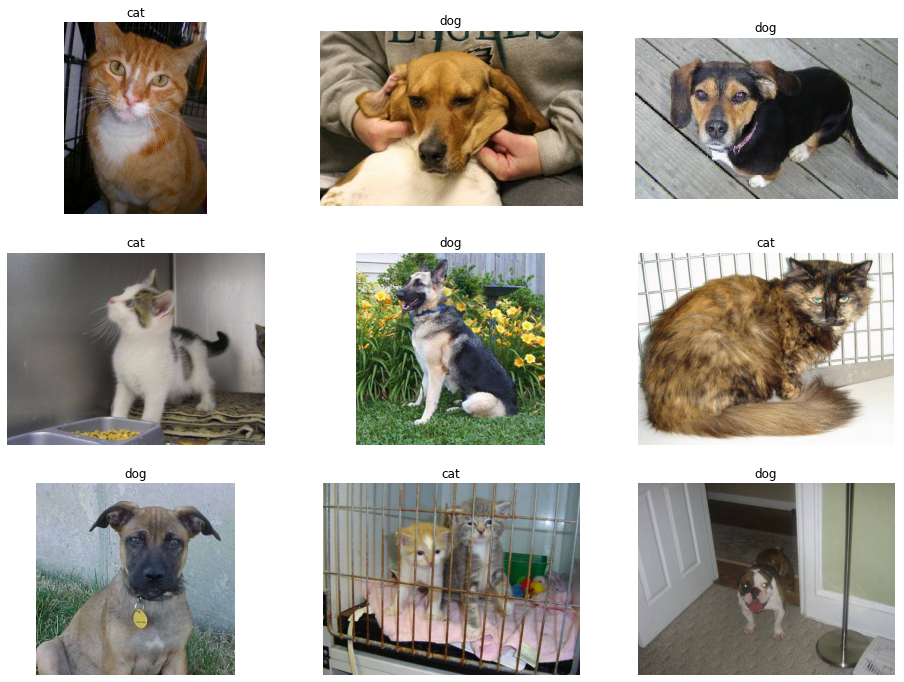

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
    ax.imshow(img)


## Split

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

## Load Datasets

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [ ]:
# Training settings
batch_size = 32

In [ ]:
train_data = CatsDogsDataset(train_list, transform=transforms)
valid_data = CatsDogsDataset(valid_list, transform=transforms)
test_data = CatsDogsDataset(test_list, transform=transforms)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_data), len(train_loader))

20000 625


In [ ]:
print(len(valid_data), len(valid_loader))

5000 157


## Pretrained VIT

In [ ]:
!pip install pytorch-pretrained-vit

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-cp36-none-any.whl size=11132 sha256=3aa64787a3e3c98d765efafbef4e5f80e32d94aa45d81e3d6c39fe3c38be9e62
  Stored in directory: /root/.cache/pip/wheels/b8/e9/a9/bf3f411475804be42190a13be925e65a63fdf30e1a469a9fe8
Successfully built pytorch-pretrained-vit


In [ ]:
import pytorch_pretrained_vit
model_name = 'B_16_imagenet1k'
model = pytorch_pretrained_vit.ViT(model_name, image_size=224, pretrained=True)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth



Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 197, 768])
Loaded pretrained weights.


In [ ]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0, deep=0, max_deep=2):
    for name, next_layer in layer.named_children():
        if deep > max_deep:
            return
        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4, deep + 1, max_deep=max_deep)

model_structure(model, max_deep=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

patch_embedding
positional_embedding
transformer:
             blocks:
                     0:
                     1:
                     2:
                     3:
                     4:
                     5:
                     6:
                     7:
                     8:
                     9:
                     10:
                     11:
norm
fc
The model has 86,567,656 trainable parameters


In [ ]:
# change ouput layer
# firstly you can train only the last fc layer then finetune all layers
model.fc = nn.Linear(768, 2)
model = model.to(device)

### Training

In [ ]:
params = [param for name, param in model.named_parameters()]
# for param in params[:-2]:
#      param.requires_grad=True
optimizer = optim.Adam([
    {"params": params[-2:], "lr": 3e-3},
    {"params": params[:-2],"lr": 2e-5}
])
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
criterion = nn.CrossEntropyLoss()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 85,800,194 trainable parameters


In [ ]:
def train(model, iterator, optimizer, scheduler, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    i = 0
    for data, label in tqdm(iterator):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        i += 1
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%20==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    scheduler.step()
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
    
        for data, label in iterator:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

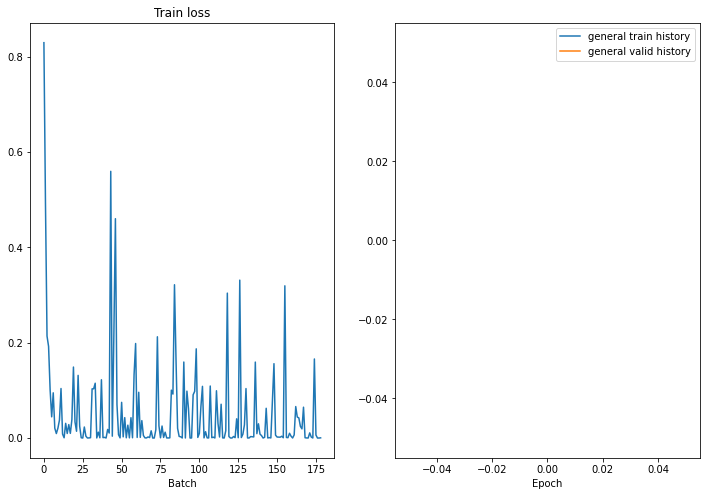

KeyboardInterrupt: ignored

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, scheduler, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [ ]:
# best_model.load_state_dict(torch.load('best-val-model.pt'))
best_model = model
best_model.eval()


pred_labels = []
true_labels = []
epoch_loss = 0

with torch.no_grad():
     for data, label in tqdm(valid_loader):
        data = data.to(device)
        true_labels.append(label.numpy())

        output = model(data)
        loss = criterion(output, label.to(device))
        epoch_loss += loss.item()
        pred_labels.append(output.argmax(dim=1).cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
print(f'Accurqacy score: {accuracy_score(true_labels, pred_labels)}')
print(f"Loss: {epoch_loss / len(valid_loader)}")

Accurqacy score: 0.9946
Loss: 0.02124833992365024


In [ ]:
best_model = model
best_model.eval()


prob = []
true_labels = []

with torch.no_grad():
     for data, label in tqdm(test_loader):
        data = data.to(device)
        true_labels.append(label.numpy())

        output = model(data)
        prob.append(output.cpu().numpy())

In [ ]:
import re
to_id = lambda x: int(re.sub(r'[^0-9]', '', x))
my_id = list(map(to_id, test_list))

In [ ]:
logits = np.concatenate(prob, axis=0)
answer = np.exp(logits[:, 1]) / np.sum(np.exp(logits), axis=1)

submit['label'] = answer
submit['id'] = my_id
submit.sort_values(by='id', inplace=True)
submit.head()

,id,label
9692,1,1.000000
1844,2,0.999978
7633,3,0.999979
4621,4,1.000000
5714,5,0.000008


In [ ]:
submit.to_csv('submission.csv', index=False)